In [156]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt 
from PIL import Image
import os 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchinfo import summary
import torchvision.models as models

# 전처리 & dataset 생성

In [157]:
preprocessing = transforms.Compose([
    transforms.Resize(size = (200, 200)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [158]:
file_dir = './8moods'
imgDS = ImageFolder(root = file_dir, transform = preprocessing)

In [159]:
print(imgDS.class_to_idx)

{'angry_mood': 0, 'anxiety_mood': 1, 'depressed_mood': 2, 'dynamic_mood': 3, 'happy_mood': 4, 'peaceful_mood': 5, 'tired_mood': 6, 'withered_mood': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


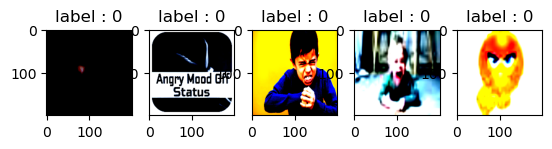

In [160]:
k = 1
for (img, label) in imgDS:
    plt.subplot(1,5,k)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"label : {label}")
    k += 1
    if k == 6 : break
plt.show()


In [161]:
seed = torch.Generator().manual_seed(42)
train, val, test = 0.7, 0.1, 0.2
trainDS, validDS, testDS = random_split(imgDS, [train, val, test], generator = seed)

# DataLoader

In [162]:
# 각 분류별로 dataloader를 생성해보자
batch_size = 10
train_dl = DataLoader(trainDS, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(validDS, batch_size = batch_size, shuffle=True)
test_dl = DataLoader(testDS, batch_size = batch_size, shuffle=True)

1개의 배치 안에 있는 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


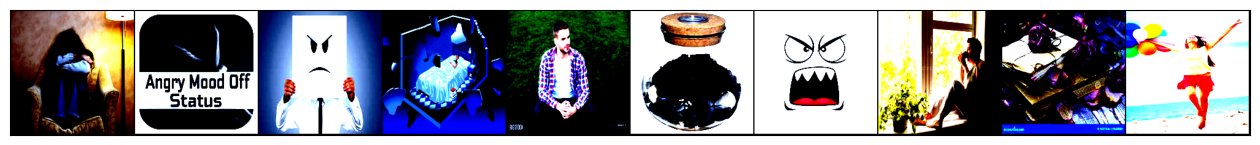

In [163]:
from torchvision.utils import make_grid

def show_batch(dl):
    """Plot images grid of single batch"""
    for (images, labels) in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

# model class 생성

cnn은 합성곱층, 풀링층, 벡터화층, 전결합층이 필요하다!

In [164]:
class model(nn.Module):
    def __init__(self, IN, OUT):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=IN, out_channels=6, kernel_size = 20, stride = 1)
                                # 채널 수           커널 수           커널사이즈       간격
        self.pool = nn.MaxPool2d(kernel_size = 10, stride = 10)
        self.fc1 = nn.Linear(6*20, 60)
        self.fc2 = nn.Linear(60, 20)
        self.fc3 = nn.Linear(20, OUT)

    
    def forward(self, k):
        k = self.conv(k)
        k = F.relu(k)
        k = self.pool(k)

        k = k.view(-1, 6*20)
        k = self.fc1(k)
        k = F.relu(k)
        k = self.fc2(k)
        k = F.relu(k)
        k = self.fc3(k)

        return k

# 학습 위한 변수 선언

In [165]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model(3, 10).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01) # lr은 default로 함

In [166]:
model

model(
  (conv): Conv2d(3, 6, kernel_size=(20, 20), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=120, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)

# 함수 만들긔

In [167]:
import torchmetrics as mt

def training(DATALOADER):
    model.train()
    for (feature, target) in DATALOADER:
        feature = feature.to(device)
        target = target.to(device)
        pred = model(feature)
        pred2 = model(feature)[1]
        print(f"feature : {feature.shape}")
        print(f"target : {target.shape}")
        print(target)
        print(f"pred:{pred.shape}")
        print(f"pred2: {pred2.shape}")
        print(pred2)
        # 손실계산
        loss = loss_fn(pred, target)

        # 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 성능
        acc = mt.Accuracy(num_labels = 8)
        print(acc)

training(train_dl)

feature : torch.Size([10, 3, 200, 200])
target : torch.Size([10])
tensor([1, 7, 7, 3, 6, 2, 3, 6, 5, 1])
pred:torch.Size([162, 10])
pred2: torch.Size([10])
tensor([-0.1980,  0.1110,  0.0811, -0.0954,  0.0642, -0.1713,  0.2377,  0.1470,
        -0.1752,  0.0506], grad_fn=<SelectBackward0>)


ValueError: Expected input batch_size (162) to match target batch_size (10).

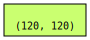

In [ ]:
from torchviz import make_dot
y_pred = torch.randint(low = 0, high = 255, size = (120, 120) )
make_dot(y_pred, params = dict(model.named_parameters()))